In [1]:
%pip install python-mnist

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from mnist import MNIST
from torch.utils.data import DataLoader, TensorDataset

# Prepare data

### Load data

In [3]:
# Downloaded from: https://kaggle.com/datasets/hojjatk/mnist-dataset/
mndata = MNIST('data')

images, labels = mndata.load_training()
print(f"Loaded {len(images)} images and {len(labels)} labels")

Loaded 60000 images and 60000 labels


### Restructure data

In [4]:
print(f"Images type: {type(images)}")
print(f"Labels type: {type(labels)}")
print(f"Image inside images type: {type(images[0])}")

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# Reshape images to 28x28
images = images.reshape(-1, 28, 28)
print(f"Images shape: {images.shape}")

Images type: <class 'list'>
Labels type: <class 'array.array'>
Image inside images type: <class 'list'>
Images shape: (60000, 784)
Labels shape: (60000,)
Images shape: (60000, 28, 28)


### Preprocess data

In [5]:
print(f"{'----- Before normalization -----'}")
print(f"Min pixel value: {np.min(images):.3f}")
print(f"Mean pixel value: {np.mean(images):.3f}")
print(f"Max pixel value: {np.max(images):.3f}")

# divide by 255 to normalize
images = images / 255.0
print(f"{'----- After normalization ------'}")
print(f"Min pixel value: {np.min(images):.3f}")
print(f"Mean pixel value: {np.mean(images):.3f}")
print(f"Max pixel value: {np.max(images):.3f}")

----- Before normalization -----
Min pixel value: 0.000
Mean pixel value: 33.318
Max pixel value: 255.000
----- After normalization ------
Min pixel value: 0.000
Mean pixel value: 0.131
Max pixel value: 1.000


### Split data

In [6]:
supervised_split = 0.01 # 1% of the data
train_split = 0.8 # 80% of the data

# shuffle data incase there is some order
np.random.seed(42)
shuffle = np.random.permutation(len(images))
images = images[shuffle]
labels = labels[shuffle]

# get data where labels are available
supervised_images = images[:int(supervised_split * len(images))]
supervised_labels = labels[:int(supervised_split * len(labels))]

# get data where labels are not available
unsupervised_images = images[int(supervised_split * len(images)):]
unsupervised_labels = labels[int(supervised_split * len(labels)):] # only for visualization!

# split both supervised and unsupervised data into train and test
supervised_train_images = supervised_images[:int(train_split * len(supervised_images))]
supervised_train_labels = supervised_labels[:int(train_split * len(supervised_labels))]
supervised_test_images = supervised_images[int(train_split * len(supervised_images)):]
supervised_test_labels = supervised_labels[int(train_split * len(supervised_labels)):]

unsupervised_train_images = unsupervised_images[:int(train_split * len(unsupervised_images))]
unsupervised_test_images = unsupervised_images[int(train_split * len(unsupervised_images)):]

unsupervised_test_labels = unsupervised_labels[int(train_split * len(unsupervised_labels)):] # only for visualization!
del unsupervised_labels

print(f"Supervised train images shape: {supervised_train_images.shape}")
print(f"Supervised train labels shape: {supervised_train_labels.shape}")
print(f"Supervised test images shape: {supervised_test_images.shape}")
print(f"Supervised test labels shape: {supervised_test_labels.shape}")
print(f"Unsupervised train images shape: {unsupervised_train_images.shape}")
print(f"Unsupervised test images shape: {unsupervised_test_images.shape}")

Supervised train images shape: (480, 28, 28)
Supervised train labels shape: (480,)
Supervised test images shape: (120, 28, 28)
Supervised test labels shape: (120,)
Unsupervised train images shape: (47520, 28, 28)
Unsupervised test images shape: (11880, 28, 28)


# Analyze data

### Visualize data

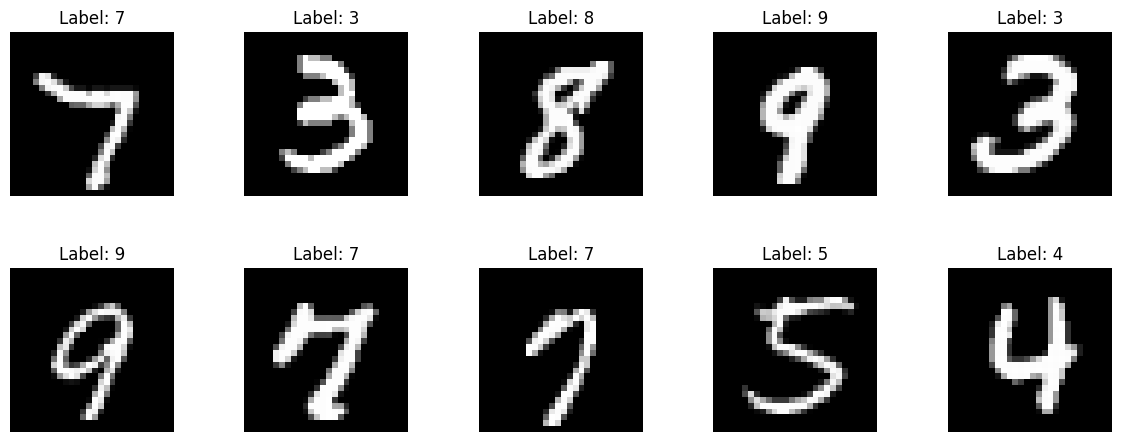

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
fig.tight_layout(pad=2.0)

for i in range(10):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(supervised_train_images[i], cmap='gray')
    axs[row, col].set_title(f"Label: {supervised_train_labels[i]}")
    axs[row, col].axis('off')

plt.show()

### Visualize target distributions

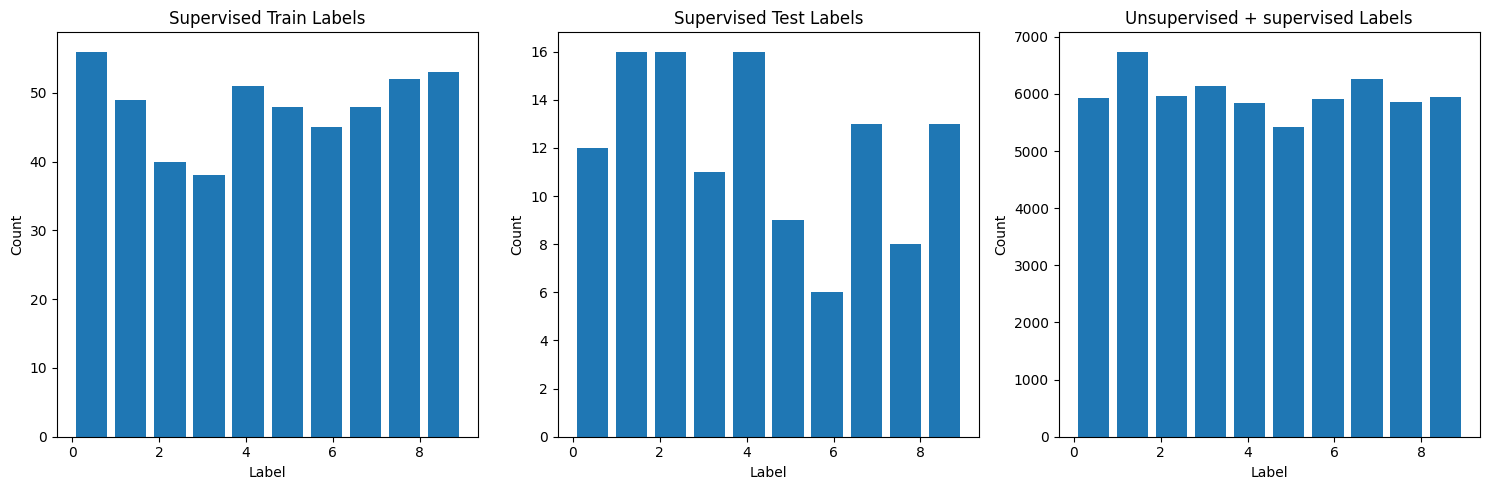

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for supervised train labels
axs[0].hist(supervised_train_labels, bins=10, rwidth=0.8)
axs[0].set_title("Supervised Train Labels")
axs[0].set_xlabel("Label")
axs[0].set_ylabel("Count")

# Plot for supervised test labels
axs[1].hist(supervised_test_labels, bins=10, rwidth=0.8)
axs[1].set_title("Supervised Test Labels")
axs[1].set_xlabel("Label")
axs[1].set_ylabel("Count")

# Plot for general labels
axs[2].hist(labels, bins=10, rwidth=0.8)
axs[2].set_title("Unsupervised + supervised Labels")
axs[2].set_xlabel("Label")
axs[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Train autoencoder

In [9]:
cuda = True
device = torch.device("cuda" if torch.cuda.is_available() and cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


### architecture

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (28, 28)),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Prepare training

In [11]:
# Hyperparameters
latent_dim = 2
epochs = 200
batch_size = 512
learning_rate = 1e-3
patience = 3
criterion = nn.MSELoss()

autoencoder = Autoencoder(latent_dim=latent_dim)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
# Send model to GPU if available
if device.type == "cuda":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device)

# Prepare data
unsupervised_train_images = TensorDataset(torch.tensor(unsupervised_train_images, device=device, dtype=torch.float32))
unsupervised_test_images = TensorDataset(torch.tensor(unsupervised_test_images, device=device, dtype=torch.float32))

train_loader = DataLoader(unsupervised_train_images, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(unsupervised_test_images, batch_size=batch_size, shuffle=False)

### Train autoencoder

In [12]:
def train_ae():
    # can leak test data with early stopping on test loss.
    # but the unsupervised data is probably big enough so it won't matter much
    best_test_loss = float('inf') 
    epochs_no_improve = 0

    global train_loss_history, test_loss_history
    train_loss_history = []
    test_loss_history = []
    for epoch in range(epochs):
        # Train part
        autoencoder.train()
        running_loss = 0.0
        for data, in train_loader:
            optimizer.zero_grad()
            outputs = autoencoder(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)  # multiply by batch size
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)

        # Eval part
        autoencoder.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, in test_loader:
                outputs = autoencoder(data)
                loss = criterion(outputs, data)
                test_loss += loss.item() * data.size(0)  # multiply by batch size
        test_loss = test_loss / len(test_loader.dataset)
        test_loss_history.append(test_loss)

        print(f"Epoch {epoch + 1}/{epochs} done, train loss: {epoch_loss:.3f}, test loss: {test_loss:.3f}")

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

train_ae()

Epoch 1/200 done, train loss: 0.084, test loss: 0.062
Epoch 2/200 done, train loss: 0.057, test loss: 0.053
Epoch 3/200 done, train loss: 0.052, test loss: 0.050
Epoch 4/200 done, train loss: 0.049, test loss: 0.048
Epoch 5/200 done, train loss: 0.047, test loss: 0.046
Epoch 6/200 done, train loss: 0.046, test loss: 0.045
Epoch 7/200 done, train loss: 0.045, test loss: 0.044
Epoch 8/200 done, train loss: 0.044, test loss: 0.044
Epoch 9/200 done, train loss: 0.044, test loss: 0.043
Epoch 10/200 done, train loss: 0.043, test loss: 0.043
Epoch 11/200 done, train loss: 0.043, test loss: 0.043
Epoch 12/200 done, train loss: 0.043, test loss: 0.042
Epoch 13/200 done, train loss: 0.042, test loss: 0.042
Epoch 14/200 done, train loss: 0.042, test loss: 0.042
Epoch 15/200 done, train loss: 0.042, test loss: 0.042
Epoch 16/200 done, train loss: 0.042, test loss: 0.041
Epoch 17/200 done, train loss: 0.041, test loss: 0.041
Epoch 18/200 done, train loss: 0.041, test loss: 0.041
Epoch 19/200 done, 

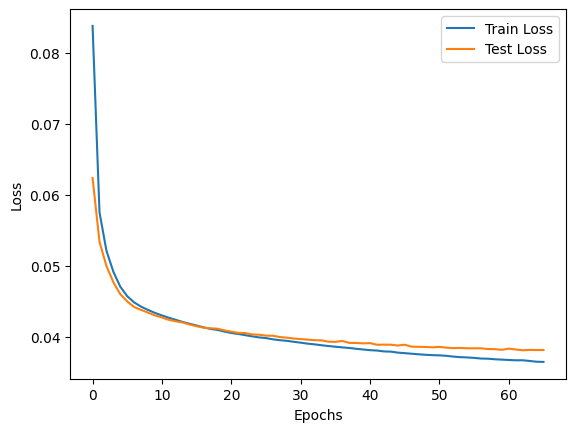

In [13]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualize reconstruction

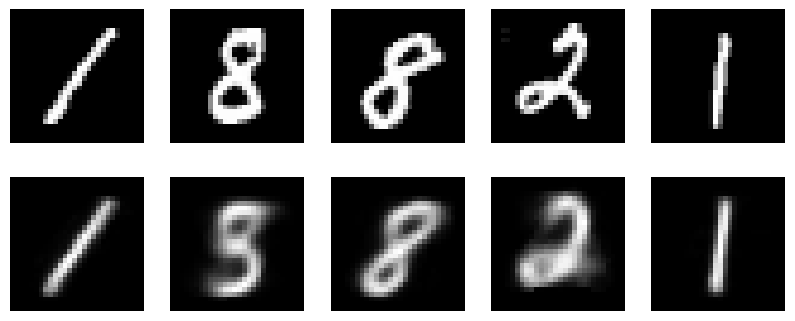

In [14]:
num_images = 5
example_images = unsupervised_test_images[:num_images][0]

autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(example_images)

fig, axes = plt.subplots(2, num_images, figsize=(10, 4))

# Original Images
for i in range(num_images):
    axes[0, i].imshow(example_images[i].cpu().numpy(), cmap='gray')
    axes[0, i].axis('off')

# Reconstructions
for i in range(num_images):
    axes[1, i].imshow(reconstructions[i].cpu().numpy(), cmap='gray')
    axes[1, i].axis('off')

plt.show()

### Visualize latent space

Test latent vectors shape: (11880, 2)


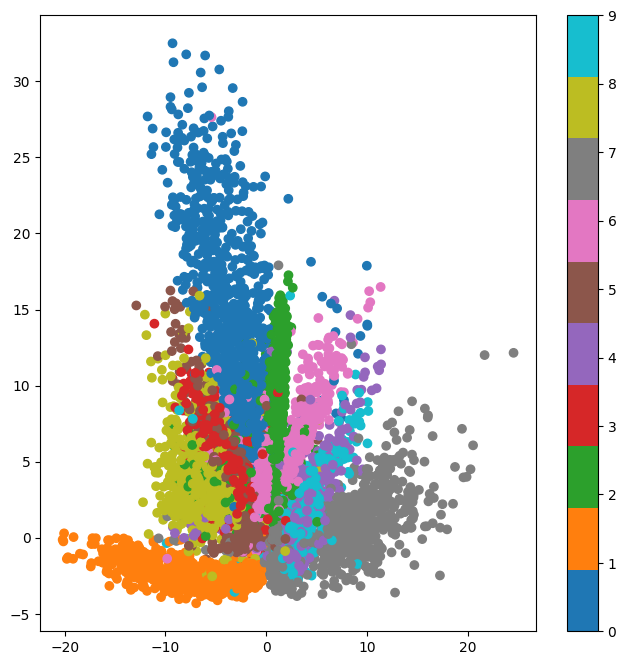

In [15]:
autoencoder.eval()
test_latent_vectors = []
with torch.no_grad():
    for data, in test_loader:
        outputs = autoencoder.encoder(data)
        test_latent_vectors.append(outputs.cpu().numpy())
test_latent_vectors = np.concatenate(test_latent_vectors)
print(f"Test latent vectors shape: {test_latent_vectors.shape}")

# Plot latent vectors and color by unsupervised_test_labels
plt.figure(figsize=(8, 8))
plt.scatter(test_latent_vectors[:, 0], test_latent_vectors[:, 1], c=unsupervised_test_labels, cmap='tab10')
plt.colorbar()
plt.show()

### Bigger latent space

In [16]:
latent_dim = 16
autoencoder = Autoencoder(latent_dim=latent_dim)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
# Send model to GPU if available
if device.type == "cuda":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device)
train_ae()

Epoch 1/200 done, train loss: 0.087, test loss: 0.062
Epoch 2/200 done, train loss: 0.052, test loss: 0.041
Epoch 3/200 done, train loss: 0.037, test loss: 0.033
Epoch 4/200 done, train loss: 0.031, test loss: 0.029
Epoch 5/200 done, train loss: 0.028, test loss: 0.027
Epoch 6/200 done, train loss: 0.026, test loss: 0.025
Epoch 7/200 done, train loss: 0.024, test loss: 0.023
Epoch 8/200 done, train loss: 0.022, test loss: 0.021
Epoch 9/200 done, train loss: 0.020, test loss: 0.020
Epoch 10/200 done, train loss: 0.019, test loss: 0.019
Epoch 11/200 done, train loss: 0.018, test loss: 0.018
Epoch 12/200 done, train loss: 0.017, test loss: 0.017
Epoch 13/200 done, train loss: 0.017, test loss: 0.017
Epoch 14/200 done, train loss: 0.016, test loss: 0.016
Epoch 15/200 done, train loss: 0.016, test loss: 0.015
Epoch 16/200 done, train loss: 0.015, test loss: 0.015
Epoch 17/200 done, train loss: 0.015, test loss: 0.015
Epoch 18/200 done, train loss: 0.014, test loss: 0.014
Epoch 19/200 done, 

# Finetune autoencoder

### Encoder + clf head

In [17]:
class EncoderClassifier(nn.Module):
    def __init__(self, encoder):
        super(EncoderClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10), # 10 classes
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

### Prepare training

In [18]:
batch_size = 16 # decrease batch size and lr since it's a smaller dataset
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()

eclf = EncoderClassifier(autoencoder.encoder)
optimizer = optim.Adam(eclf.parameters(), lr=learning_rate)
# Send model to GPU if available
if device.type == "cuda":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    eclf.to(device)

# Prepare data
supervised_train_images = TensorDataset(torch.tensor(supervised_train_images, device=device, dtype=torch.float32), torch.tensor(supervised_train_labels, device=device, dtype=torch.long))
supervised_test_images = TensorDataset(torch.tensor(supervised_test_images, device=device, dtype=torch.float32), torch.tensor(supervised_test_labels, device=device, dtype=torch.long))

train_loader = DataLoader(supervised_train_images, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(supervised_test_images, batch_size=batch_size, shuffle=False)

### Finetune encoder classifier

In [19]:
def train_clf(clf):
    global train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history
    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    best_test_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Train part
        clf.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = clf(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)  # multiply by batch size
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(train_accuracy)

        # Eval part
        clf.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data, labels in test_loader:
                outputs = clf(data)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * data.size(0)  # multiply by batch size
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_loss = test_loss / len(test_loader.dataset)
        test_accuracy = 100 * correct_test / total_test
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{epochs} done, train loss: {epoch_loss:.3f}, train accuracy: {train_accuracy:.2f}%, test loss: {test_loss:.3f}, test accuracy: {test_accuracy:.2f}%")

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

train_clf(eclf)

Epoch 1/200 done, train loss: 2.319, train accuracy: 12.71%, test loss: 2.093, test accuracy: 25.00%
Epoch 2/200 done, train loss: 1.907, train accuracy: 45.21%, test loss: 1.745, test accuracy: 58.33%
Epoch 3/200 done, train loss: 1.571, train accuracy: 59.58%, test loss: 1.430, test accuracy: 64.17%
Epoch 4/200 done, train loss: 1.248, train accuracy: 70.00%, test loss: 1.133, test accuracy: 68.33%
Epoch 5/200 done, train loss: 0.967, train accuracy: 79.58%, test loss: 0.915, test accuracy: 70.83%
Epoch 6/200 done, train loss: 0.766, train accuracy: 82.71%, test loss: 0.774, test accuracy: 78.33%
Epoch 7/200 done, train loss: 0.626, train accuracy: 87.08%, test loss: 0.661, test accuracy: 78.33%
Epoch 8/200 done, train loss: 0.527, train accuracy: 89.17%, test loss: 0.579, test accuracy: 81.67%
Epoch 9/200 done, train loss: 0.445, train accuracy: 91.88%, test loss: 0.545, test accuracy: 85.00%
Epoch 10/200 done, train loss: 0.389, train accuracy: 91.67%, test loss: 0.480, test accura

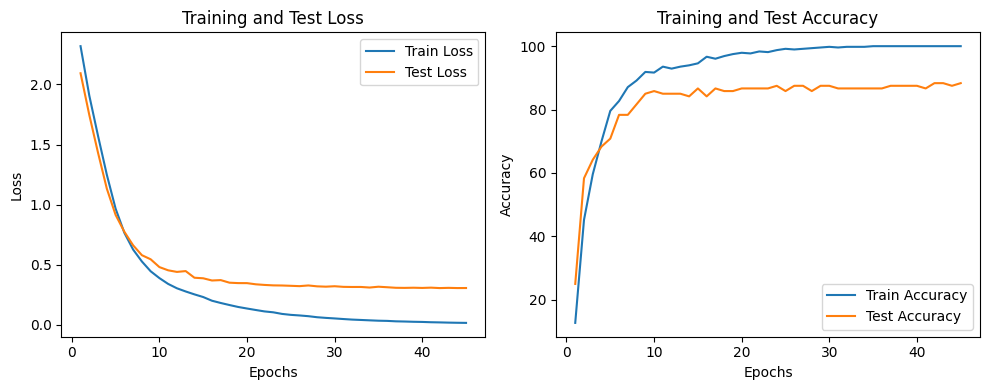

In [20]:
def plot_clf_training():
    epochs_range = range(1, len(train_loss_history) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Loss plot
    ax1.plot(epochs_range, train_loss_history, label='Train Loss')
    ax1.plot(epochs_range, test_loss_history, label='Test Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()

    # Accuracy plot
    ax2.plot(epochs_range, train_accuracy_history, label='Train Accuracy')
    ax2.plot(epochs_range, test_accuracy_history, label='Test Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_clf_training()

# Train normal classifier

### Classifier architecture

In [21]:
# Very similar architecture as encoder + classifier head
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10), # 10 classes
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

### Train regular classifier

In [22]:
# Use same hyperparameters as before
clf = Classifier()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)
# Send model to GPU if available
if device.type == "cuda":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    clf.to(device)

In [23]:
train_clf(clf)

Epoch 1/200 done, train loss: 2.295, train accuracy: 11.25%, test loss: 2.281, test accuracy: 12.50%
Epoch 2/200 done, train loss: 2.262, train accuracy: 19.79%, test loss: 2.247, test accuracy: 26.67%
Epoch 3/200 done, train loss: 2.200, train accuracy: 30.42%, test loss: 2.174, test accuracy: 34.17%
Epoch 4/200 done, train loss: 2.085, train accuracy: 42.71%, test loss: 2.050, test accuracy: 43.33%
Epoch 5/200 done, train loss: 1.910, train accuracy: 49.38%, test loss: 1.874, test accuracy: 48.33%
Epoch 6/200 done, train loss: 1.702, train accuracy: 56.88%, test loss: 1.665, test accuracy: 58.33%
Epoch 7/200 done, train loss: 1.467, train accuracy: 63.75%, test loss: 1.436, test accuracy: 70.00%
Epoch 8/200 done, train loss: 1.243, train accuracy: 73.96%, test loss: 1.243, test accuracy: 72.50%
Epoch 9/200 done, train loss: 1.054, train accuracy: 79.58%, test loss: 1.091, test accuracy: 71.67%
Epoch 10/200 done, train loss: 0.908, train accuracy: 78.96%, test loss: 0.958, test accura

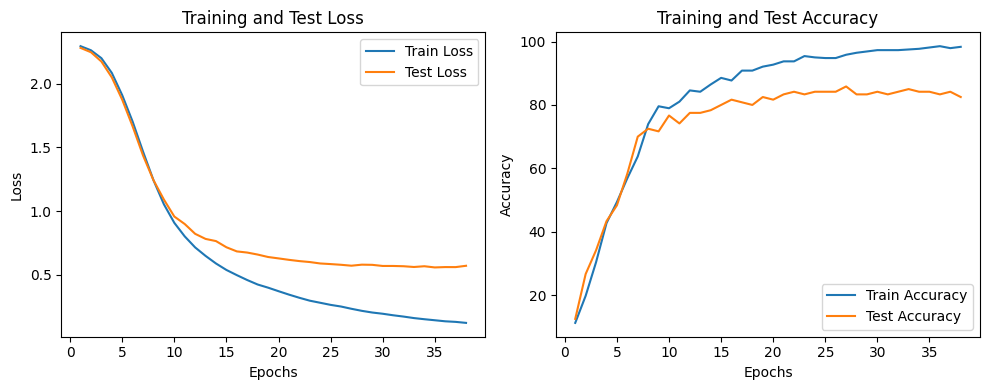

In [24]:
plot_clf_training()